In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# GLM: Linear regression

This tutorial is adapted from a [blog post by Thomas Wiecki called "The Inference Button: Bayesian GLMs made easy with PyMC3"](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/).

This tutorial appeared as a post in a small series on Bayesian GLMs on my blog:

  1. [The Inference Button: Bayesian GLMs made easy with PyMC3](http://twiecki.github.com/blog/2013/08/12/bayesian-glms-1/)
  2. [This world is far from Normal(ly distributed): Robust Regression in PyMC3](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)
  3. [The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)
  
In this blog post I will talk about:

  - How the Bayesian Revolution in many scientific disciplines is hindered by poor usability of current Probabilistic Programming languages.
  - A gentle introduction to Bayesian linear regression and how it differs from the frequentist approach.
  - A preview of [PyMC3](https://github.com/pymc-devs/pymc/tree/pymc3) (currently in alpha) and its new GLM submodule I wrote to allow creation and estimation of Bayesian GLMs as easy as frequentist GLMs in R.

Ready? Lets get started!

There is a huge paradigm shift underway in many scientific disciplines: The Bayesian Revolution. 

While the theoretical benefits of Bayesian over Frequentist stats have been discussed at length elsewhere (see *Further Reading* below), there is a major obstacle that hinders wider adoption -- *usability* (this is one of the reasons DARPA wrote out a huge grant to [improve Probabilistic Programming](http://www.darpa.mil/program/probabilistic-programming-for-advancing-machine-Learning)). 

This is mildly ironic because the beauty of Bayesian statistics is their generality. Frequentist stats have a bazillion different tests for every different scenario. In Bayesian land you define your model exactly as you think is appropriate and hit the *Inference Button(TM)* (i.e. running the magical MCMC sampling algorithm).

Yet when I ask my colleagues why they use frequentist stats (even though they would like to use Bayesian stats) the answer is that software packages like SPSS or R make it very easy to run all those individuals tests with a single command (and more often then not, they don't know the exact model and inference method being used).

While there are great Bayesian software packages like [JAGS](http://mcmc-jags.sourceforge.net/), [BUGS](http://www.mrc-bsu.cam.ac.uk/bugs/), [Stan](http://mc-stan.org/) and [PyMC](http://pymc-devs.github.io/pymc/), they are written for Bayesians statisticians who know very well what model they want to build. 

Unfortunately, ["the vast majority of statistical analysis is not performed by statisticians"](http://simplystatistics.org/2013/06/14/the-vast-majority-of-statistical-analysis-is-not-performed-by-statisticians/) -- so what we really need are tools for *scientists* and not for statisticians.

In the interest of putting my code where my mouth is I wrote a submodule for the upcoming [PyMC3](https://github.com/pymc-devs/pymc/tree/pymc3) that makes construction of Bayesian Generalized Linear Models (GLMs) as easy as Frequentist ones in R.

## Linear Regression

While future blog posts will explore more complex models, I will start here with the simplest GLM -- linear regression.
In general, frequentists think about Linear Regression as follows:

$$ Y = X\beta + \epsilon $$

where $Y$ is the output we want to predict (or *dependent* variable), $X$ is our predictor (or *independent* variable), and $\beta$ are the coefficients (or parameters) of the model we want to estimate. $\epsilon$ is an error term which is assumed to be normally distributed. 

We can then use Ordinary Least Squares or Maximum Likelihood to find the best fitting $\beta$.

## Probabilistic Reformulation


Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be rewritten to yield:

$$ Y \sim \mathcal{N}(X \beta, \sigma^2) $$

In words, we view $Y$ as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance $\sigma^2$.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

 - Priors: We can quantify any prior knowledge we might have by placing priors on the paramters. For example, if we think that $\sigma$ is likely to be small we would choose a prior with more probability mass on low values.
 - Quantifying uncertainty: We do not get a single estimate of $\beta$ as above but instead a complete posterior distribution about how likely different values of $\beta$ are. For example, with few data points our uncertainty in $\beta$ will be very high and we'd be getting very wide posteriors.

## Bayesian GLMs in PyMC3

With the new GLM module in PyMC3 it is very easy to build this and much more complex models.

First, lets import the required modules.

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.1


In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

### Generating data

Create some toy data to play around with and scatter-plot it. 

Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.

In [4]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

In [5]:
data.describe()

,x,y
count,200.00000,200.000000
mean,0.50000,2.075917
std,0.29085,0.792964
min,0.00000,0.047125
25%,0.25000,1.545484
50%,0.50000,2.030129
75%,0.75000,2.639124
max,1.00000,4.721245


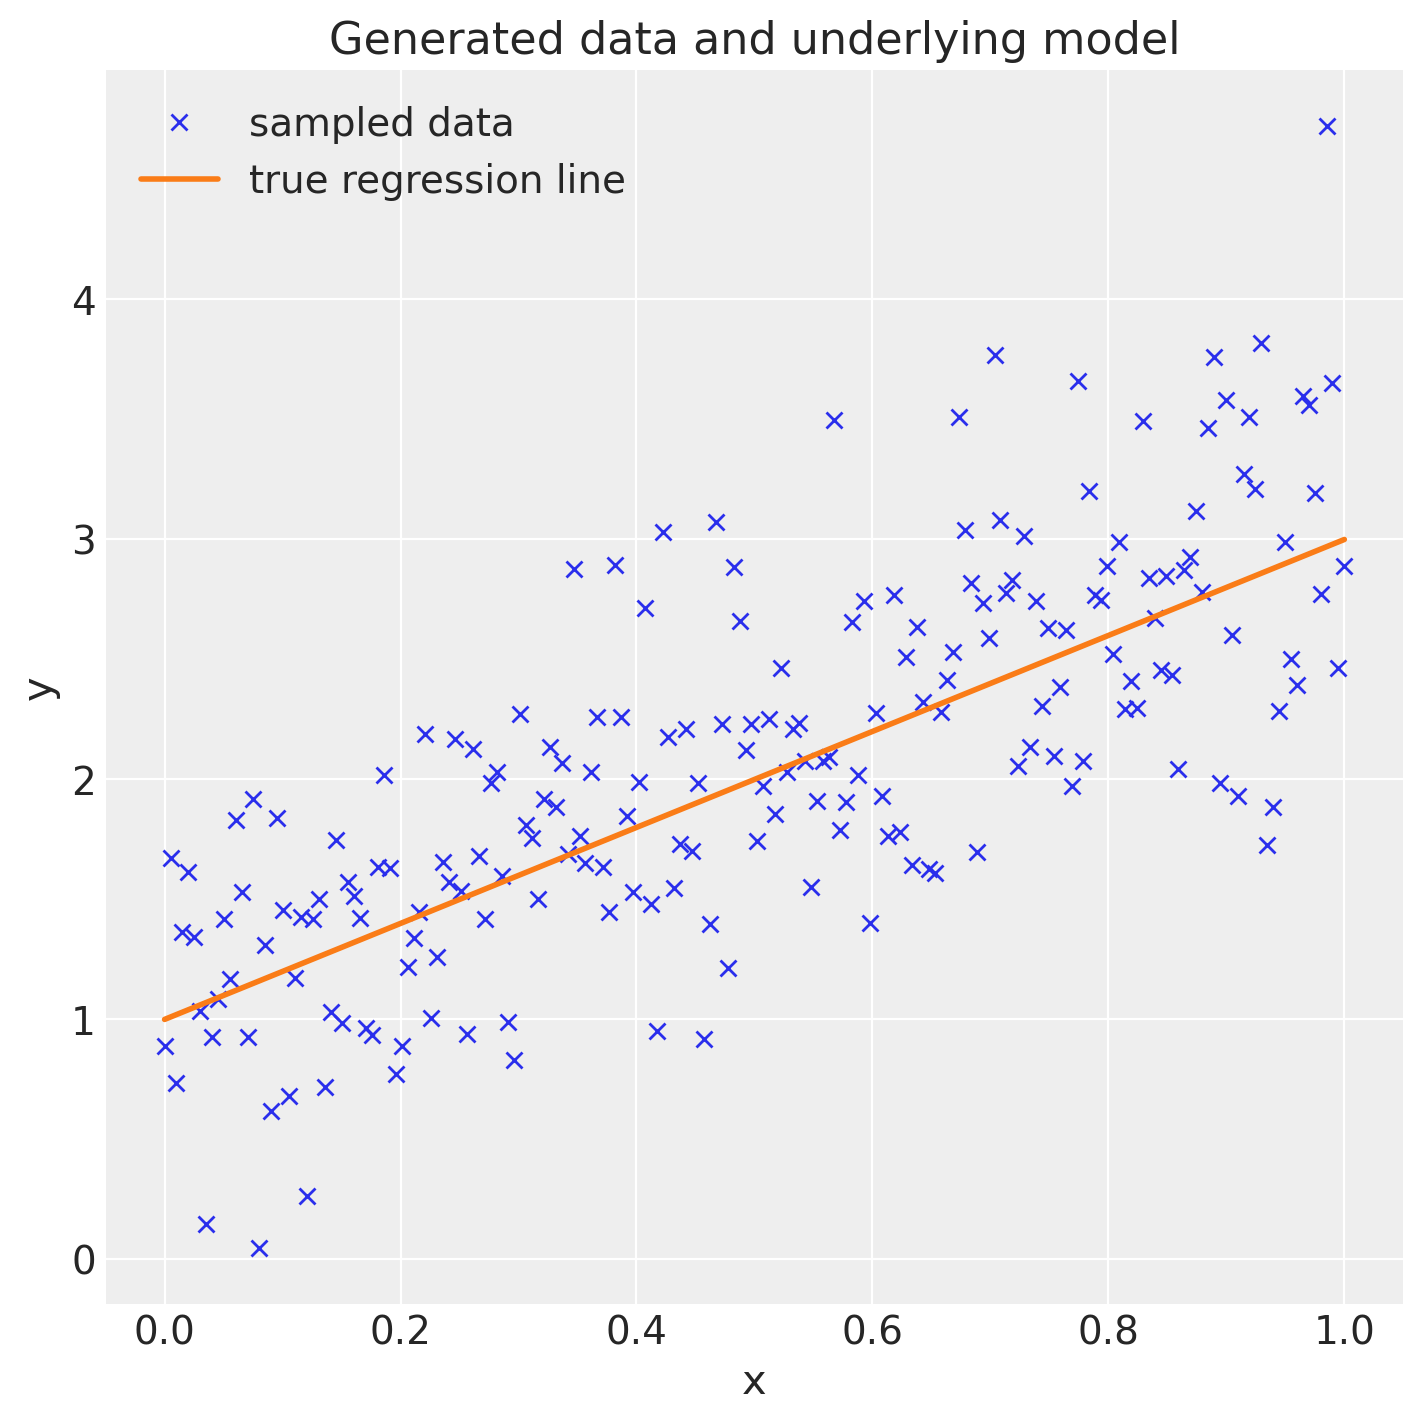

In [6]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

### Estimating the model

Lets fit a Bayesian linear regression model to this data. As you can see, model specifications in `PyMC3` are wrapped in a `with` statement. 

Here we use the awesome new [NUTS sampler](http://arxiv.org/abs/1111.4246) (our Inference Button) to draw 2000 posterior samples.

In [7]:
with Model() as model:
    #Defining Priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal ("Intercept", 0, sigma=20)
    x_coeff = Normal("x", 0, sigma=20)
    
    #Defining likelihood
    likelihood = Normal("y", mu=intercept+x_coeff*x, sigma=sigma, observed=y)
    
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8885492257282999, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867100503911816, but should be close to 0.8. Try to increase the number of tuning steps.


This should be fairly readable for people who know probabilistic programming. However, would my non-statistican friend know what all this does? Moreover, recall that this is an extremely simple model that would be one line in R. Having multiple, potentially transformed regressors, interaction terms or link-functions would also make this much more complex and error prone. 

The [`bambi`](https://bambinos.github.io/bambi/master/index.html) library instead takes a [formulae](https://bambinos.github.io/formulae/) linear model specifier from which it creates a design matrix. `bambi` then adds random variables for each of the coefficients and an appopriate likelihood to the model. 



In [8]:
model = bmb.Model("y~x", data)
trace = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 22 seconds.


Much shorter, but this code does the exact same thing as the above model specification (you can change priors and everything else too if we wanted). `bambi` parses the `formulae` model string, adds random variables for each regressor (`Intercept` and slope `x` in this case), adds a likelihood (by default, a Normal is chosen), and all other variables (`sigma`). Finally, `bambi` then initializes the parameters to a good starting point by estimating a frequentist linear model using [statsmodels](http://statsmodels.sourceforge.net/devel/).

If you are not familiar with R's syntax, `'y ~ x'` specifies that we have an output variable `y` that we want to estimate as a linear function of `x`.

### Analyzing the model

Bayesian inference does not give us only one best fitting line (as maximum likelihood does) but rather a whole posterior distribution of likely parameters. Lets plot the posterior distribution of our parameters and the individual samples we drew.

In [9]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

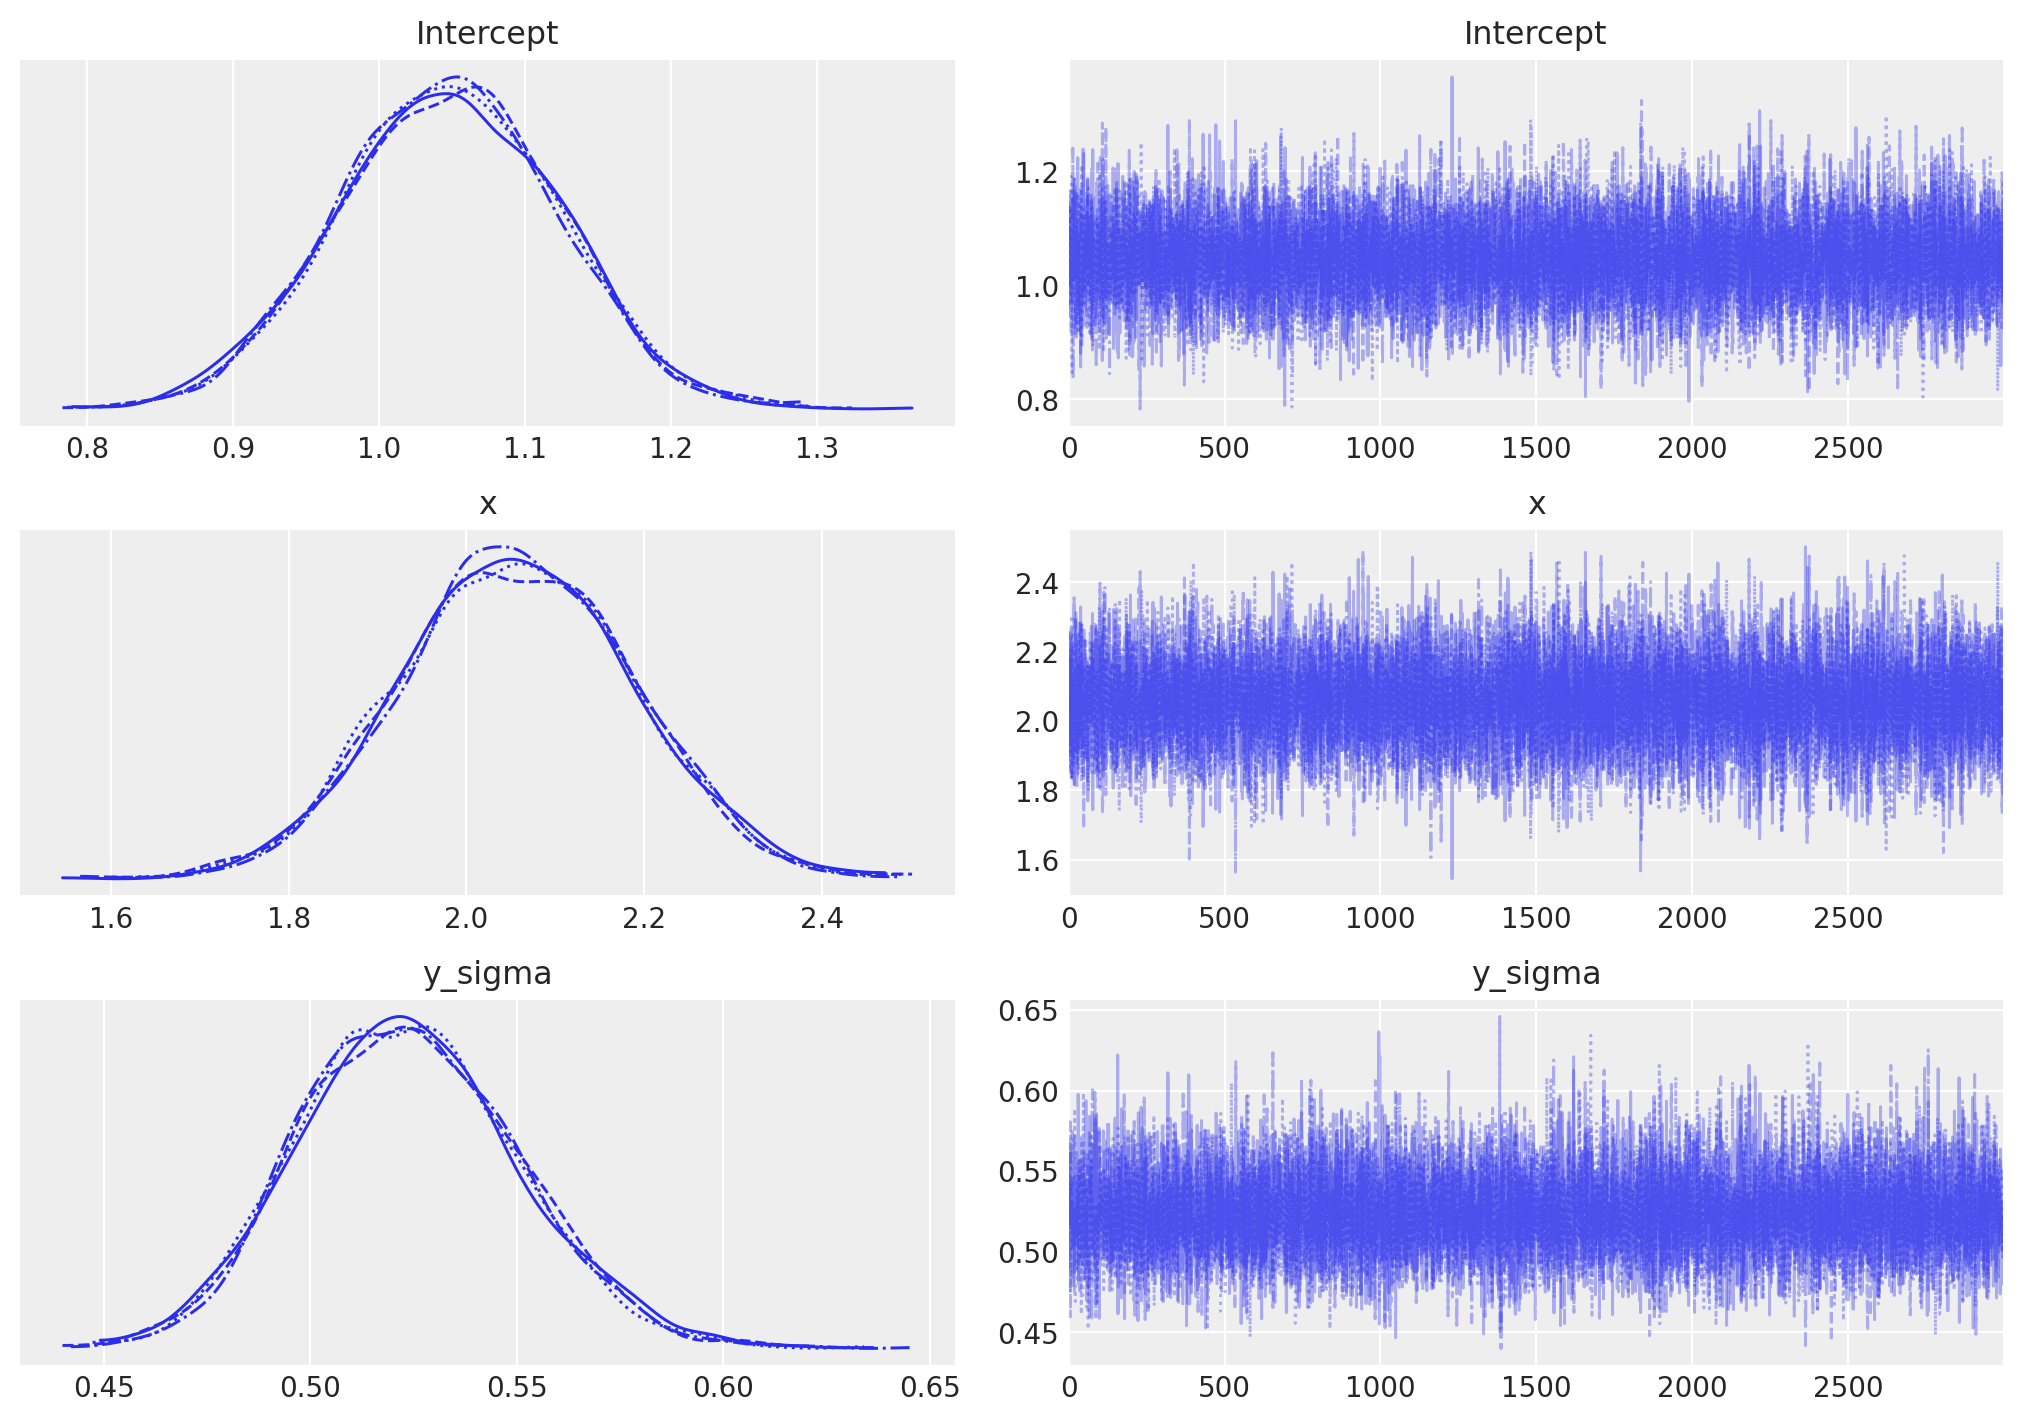

In [10]:
az.plot_trace(trace, figsize=(10, 7));

The left side shows our marginal posterior -- for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (`x` is the regression coefficient and `sigma` is the standard deviation of our normal).

In GLMs, we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. Here we are using the `plot_posterior_predictive_glm()` convenience function for this.

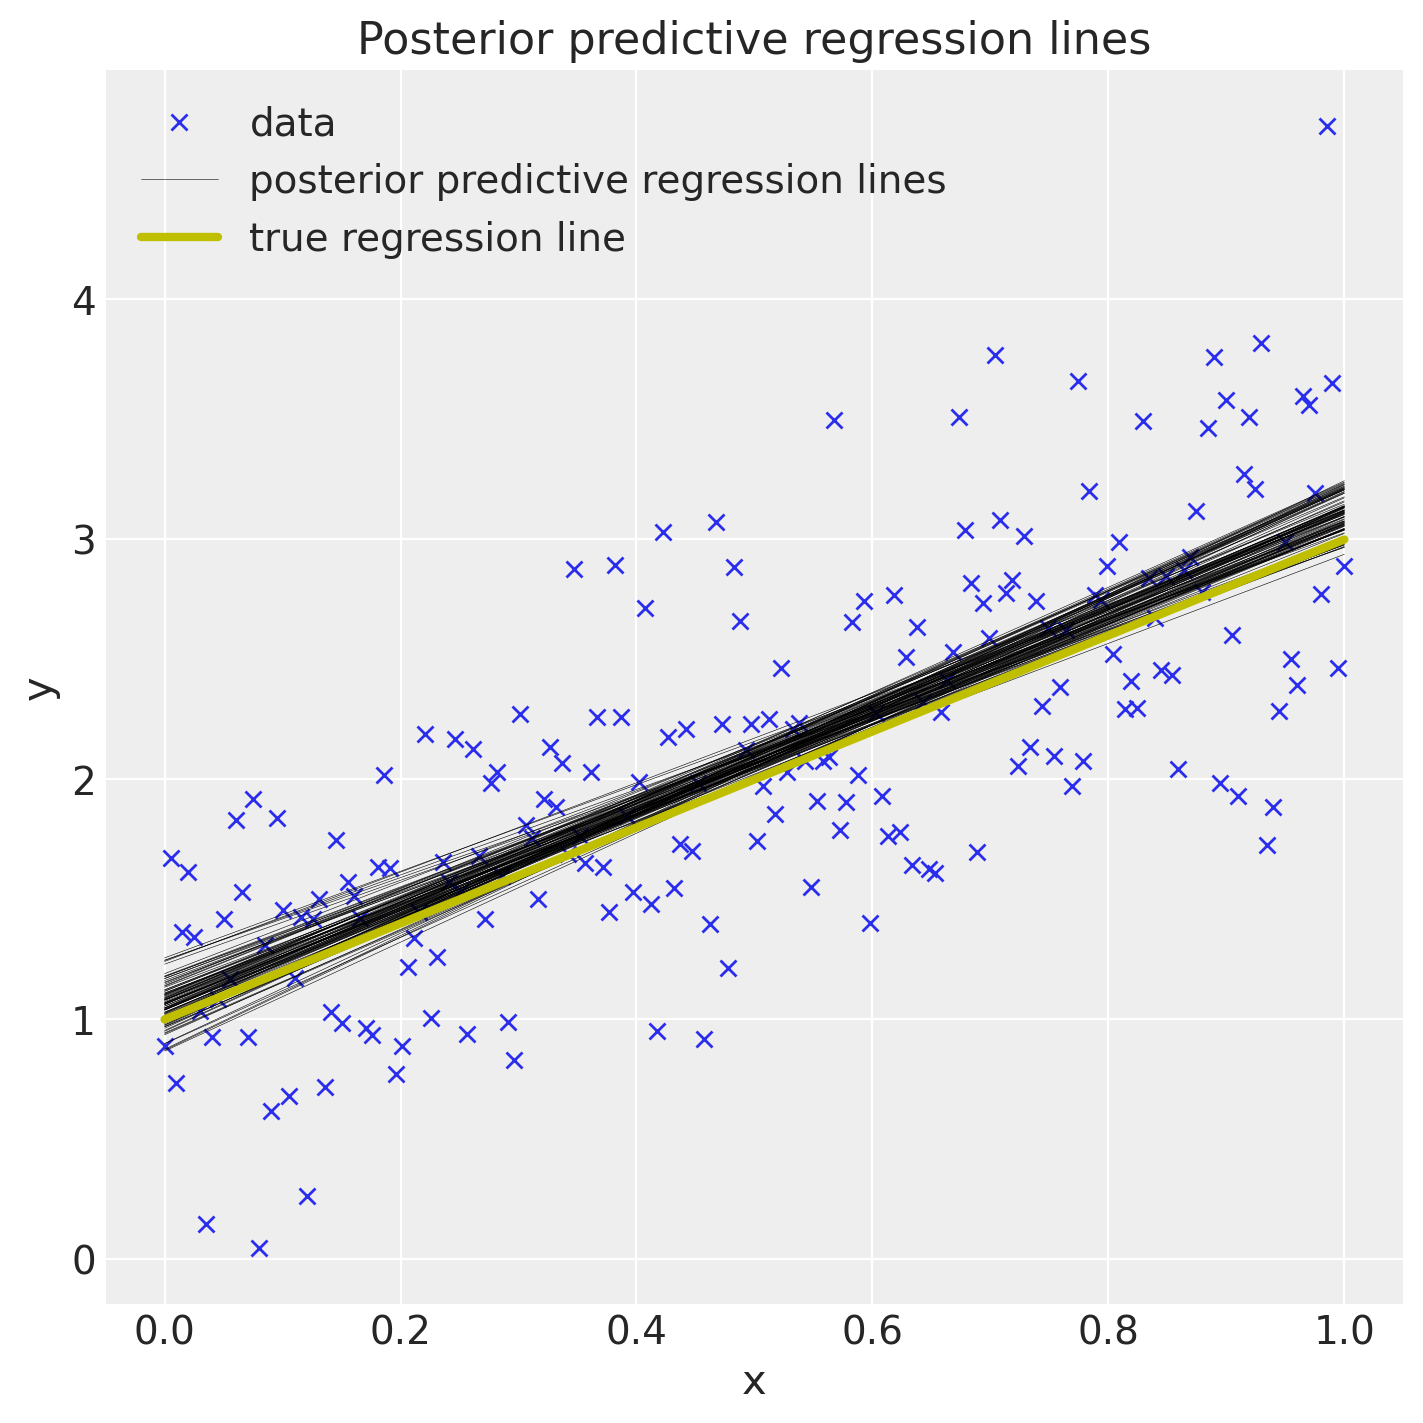

In [11]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "x", label="data")
plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have *uncertainty* in our estimates, here expressed by the variability of the lines.

## Summary

 - Usability is currently a huge hurdle for wider adoption of Bayesian statistics.
 - `Bambi` allows GLM specification with convenient syntax borrowed from R. Inference can then be carried out with `pymc3`.
 - Posterior predictive plots allow us to evaluate fit and our uncertainty in it.

### Further reading

This is the first post of a small series on Bayesian GLMs I am preparing. Next week I will describe how the Student T distribution can be used to perform robust linear regression.

Then there are also other good resources on Bayesian statistics:

  - The excellent book [Doing Bayesian Data Analysis by John Kruschke](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/).
  - [Andrew Gelman's blog](http://andrewgelman.com/)
  - [Baeu Cronins blog post on Probabilistic Programming](https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1)
  
Author: Thomas Wiecki

In [9]:
%load_ext watermark

%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Mon Aug 02 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

theano: 1.1.2
xarray: 0.17.0

arviz     : 0.11.2
pandas    : 1.2.1
pymc3     : 3.11.2
matplotlib: 3.3.4
bambi     : 0.5.0
numpy     : 1.21.0

Watermark: 2.2.0

